<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '.'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
import time

def prepare_train_set_with_fe(path, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    path += '\\'
    infile = open(site_freq_path,'rb')
    site_string = pickle.load(infile)
    site_string[0] = (0, 0)
    infile.close()
    data_list = []
    for name in sorted(os.listdir(path)):
        if name.endswith('.csv'):
            with open(path+name) as f:
                user = pd.read_csv(f)
                sites_data = user['site']
                timediff_data = pd.to_datetime(user['timestamp'])
                for i in range(0, len(sites_data), window_size):
                    end = min(i+session_length, len(sites_data))
                    sites = list(sites_data[i:end])
                    unique_sites = len(set(sites))
                    timediff = []
                    for j in range(i+1, end):
                        timediff.append(int((timediff_data[j]-timediff_data[j-1]).total_seconds()))
                    if end == len(sites_data):
                        sites += [0] * (i+session_length-len(sites_data))
                        timediff += [0] * (i+session_length-len(sites_data))
                    sites = [site_string[site][0] for site in sites]
                    session_timespan = sum(timediff)
                    start_hour = timediff_data[i].hour
                    day_of_week = timediff_data[i].weekday()
                    data_list.append(sites + timediff \
                                     + [session_timespan, unique_sites, start_hour, day_of_week] \
                                     + [int(name[4:8])])
    data = pd.DataFrame(data_list, columns=feature_names)
    return data

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy #mine

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                            '10users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 
                                                 'site_freq_10users.pkl'),
                     feature_names=feature_names, session_length=10)

Wall time: 6.26 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                             '150users'), 
                      site_freq_path=os.path.join(PATH_TO_DATA, 
                                                  'site_freq_150users.pkl'),
                      feature_names=feature_names, session_length=10)

Wall time: 1min 1s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [11]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [12]:
train_data_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [13]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [14]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
# Заменил цвет Эда на aqua, так как иначе он был очень похожим с цветом Боба
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'darkblue'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

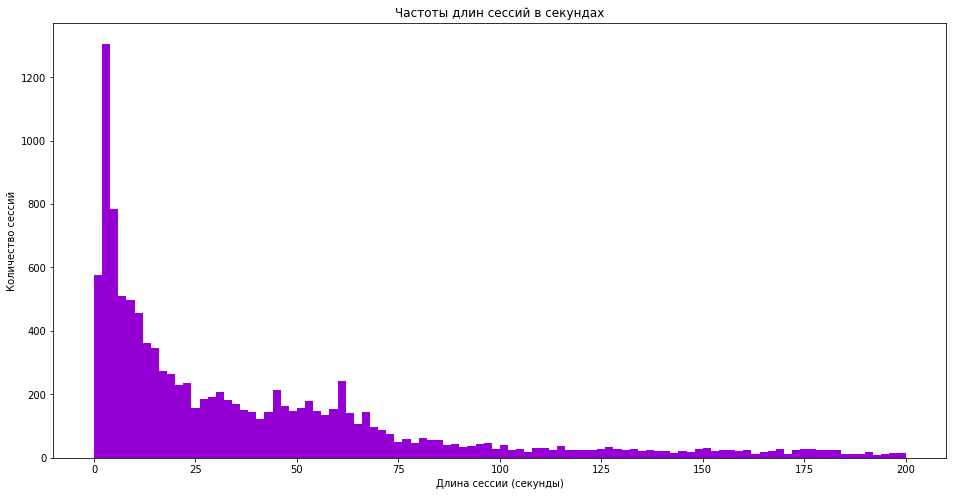

In [17]:
plt.figure(figsize=(16,8))
plt.hist(train_data_10users['session_timespan'], bins=100, range=(0,200), color='darkviolet')
plt.title('Частоты длин сессий в секундах')
plt.ylabel('Количество сессий')
plt.xlabel('Длина сессии (секунды)');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

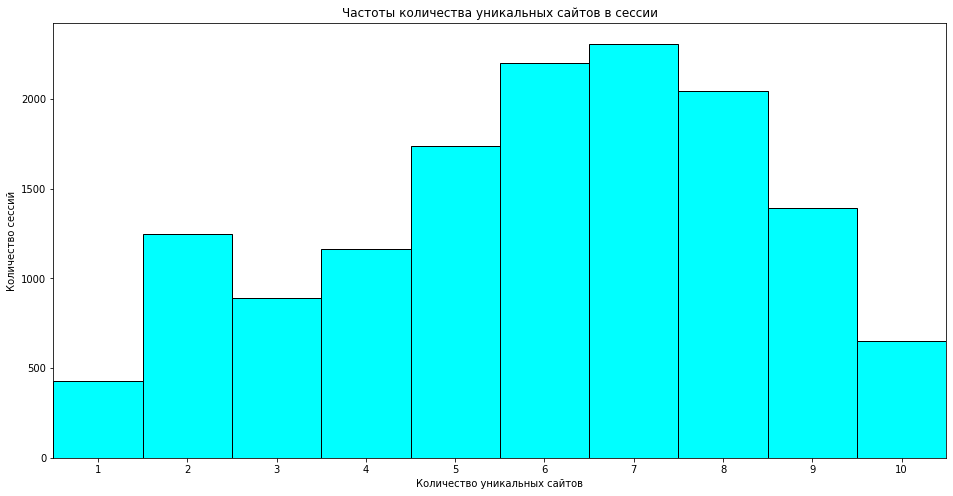

In [18]:
plt.figure(figsize=(16,8))
plt.hist(train_data_10users['#unique_sites'], bins=10, color='aqua', range=(0.5,10.5), ec='black')
plt.title('Частоты количества уникальных сайтов в сессии')
plt.ylabel('Количество сессий')
plt.xlim((0.5,10.5))
plt.xticks(range(1, 11))
plt.xlabel('Количество уникальных сайтов');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

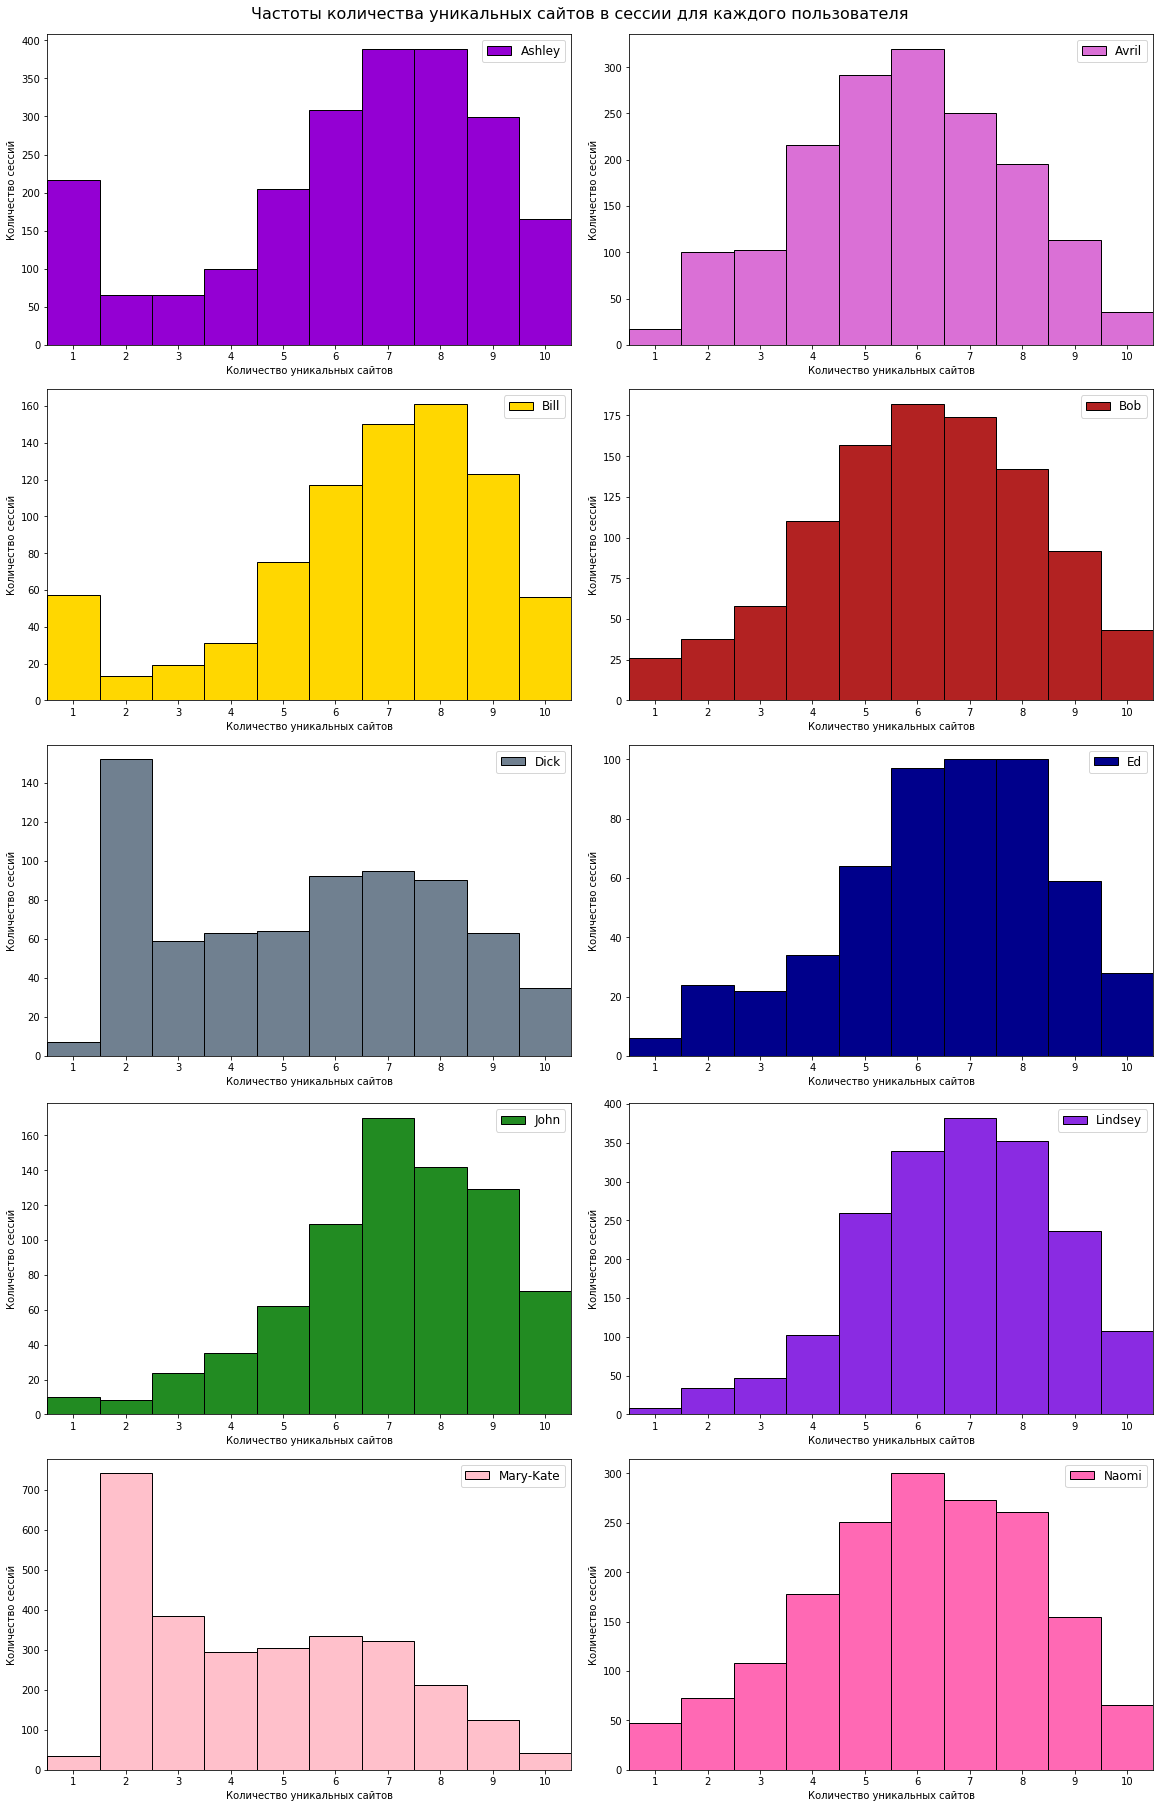

In [19]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 25), constrained_layout=True)

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    ax = axes[idx//2][idx%2]
    ax.hist(sub_df['#unique_sites'], bins=10, color=color_dic[user], range=(0.5,10.5), ec='black', label=user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlim((0.5,10.5))
    #ax.set_ylim((0,400))
    ax.set_xticks(range(1, 11))
    ax.set_xlabel('Количество уникальных сайтов');
    ax.legend(fontsize=12)
fig.suptitle('Частоты количества уникальных сайтов в сессии для каждого пользователя', fontsize=16)
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

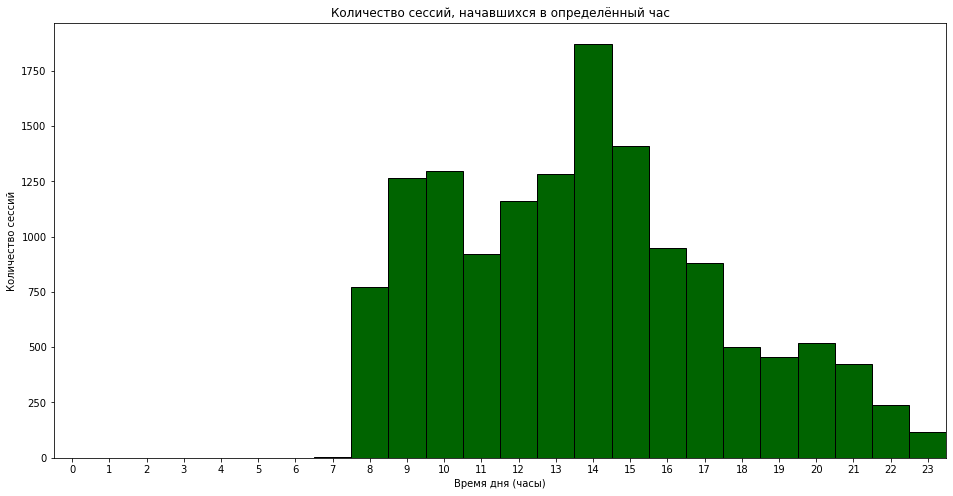

In [20]:
plt.figure(figsize=(16,8))
plt.hist(train_data_10users['start_hour'], bins=24, color='darkgreen', range=(-0.5,23.5), ec='black')
plt.title('Количество сессий, начавшихся в определённый час')
plt.ylabel('Количество сессий')
plt.xlim((-0.5,23.5))
plt.xticks(range(24))
plt.xlabel('Время дня (часы)');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

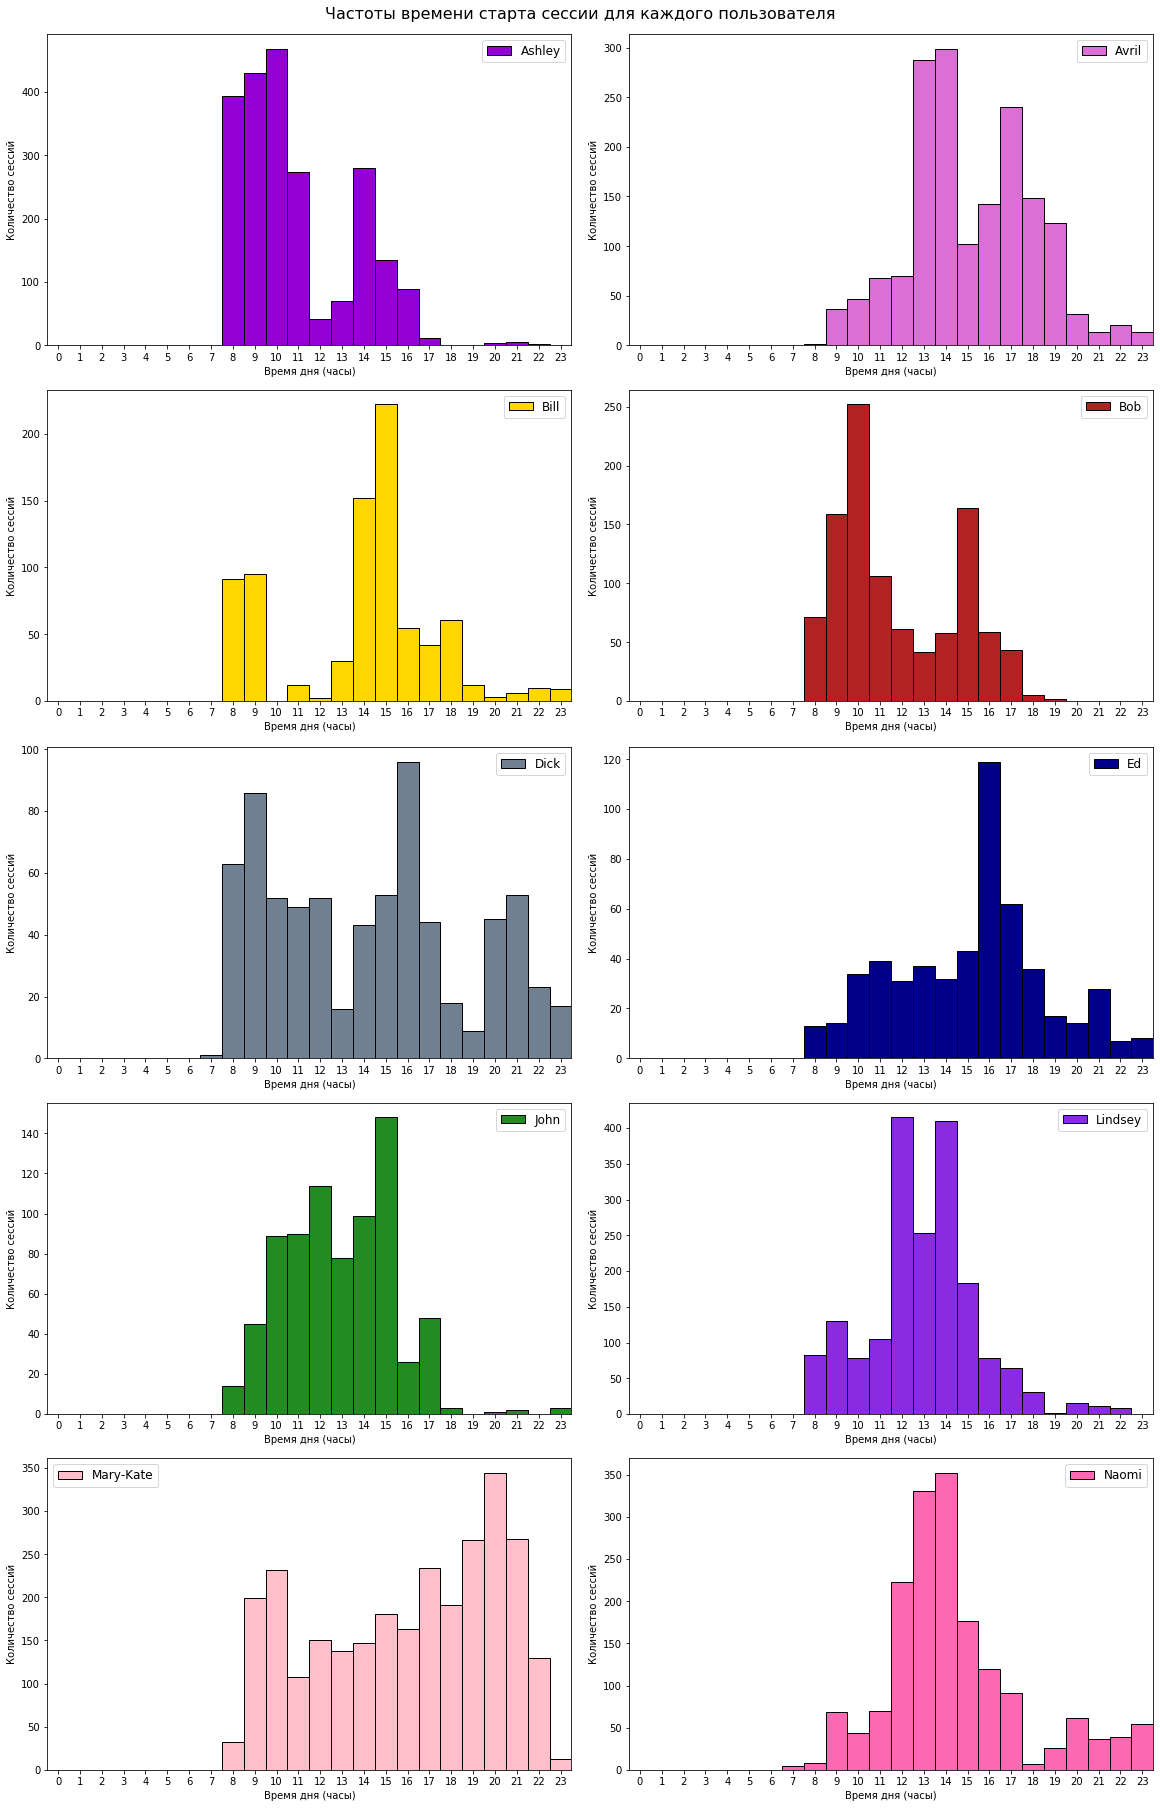

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 25), constrained_layout=True)

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    ax = axes[idx//2][idx%2]
    ax.hist(sub_df['start_hour'], bins=24, color=color_dic[user], range=(-0.5,23.5), ec='black', label=user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlim((-0.5,23.5))
    #ax.set_ylim((0,400))
    ax.set_xticks(range(24))
    ax.set_xlabel('Время дня (часы)')
    ax.legend(fontsize=12)
fig.suptitle('Частоты времени старта сессии для каждого пользователя', fontsize=16)
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

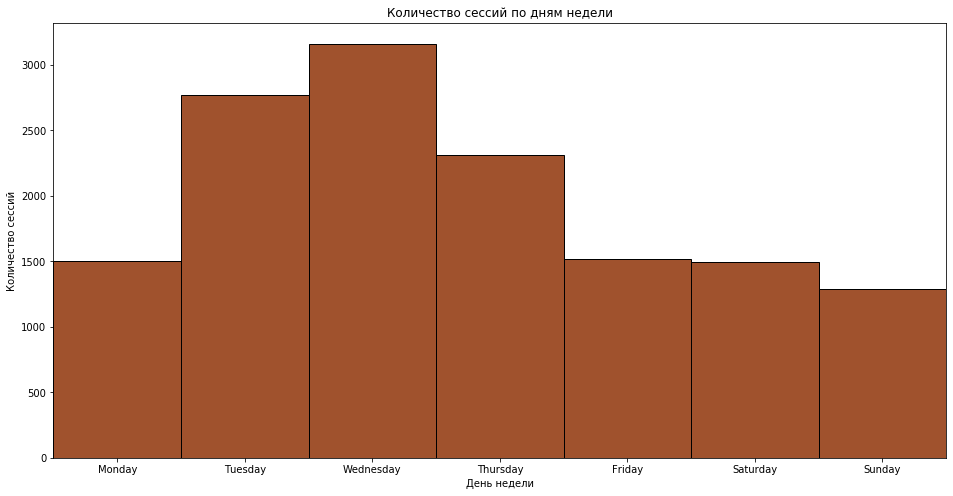

In [22]:
import calendar

plt.figure(figsize=(16,8))
plt.hist(train_data_10users['day_of_week'], bins=7, color='sienna', range=(-0.5,6.5), ec='black')
plt.title('Количество сессий по дням недели')
plt.ylabel('Количество сессий')
plt.xlim((-0.5,6.5))
plt.xticks(range(7), list(calendar.day_name)) # А уже в следующей картинке сделаю вручную
plt.xlabel('День недели');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

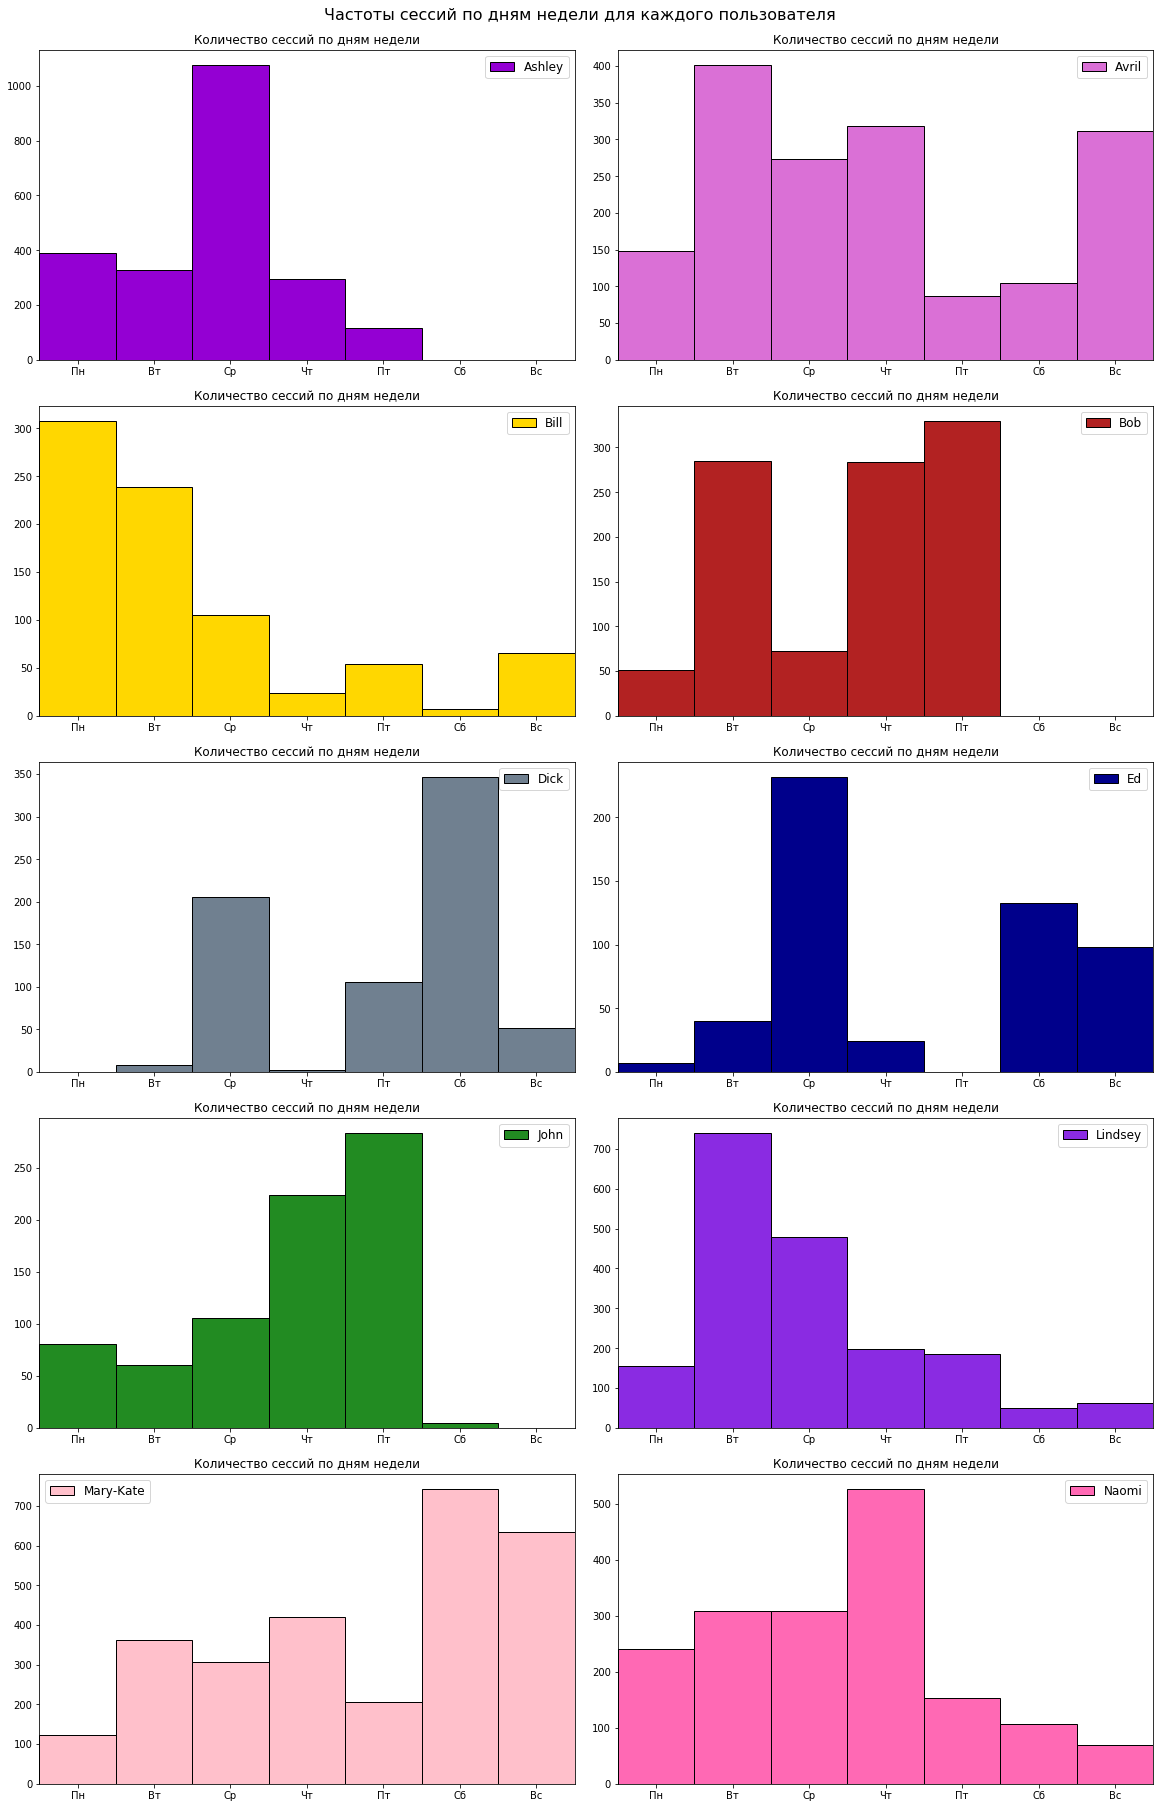

In [23]:
day_short_name = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 25), constrained_layout=True)

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(['target'])):
    ax = axes[idx//2][idx%2]
    ax.hist(sub_df['day_of_week'], bins=7, color=color_dic[user], range=(-0.5,6.5), ec='black', label=user)
    #ax.set_ylabel('Количество сессий')
    ax.set_xlim((-0.5,6.5))
    ax.set_xticks(range(7))
    ax.set_xticklabels(day_short_name)
    #ax.set_xlabel('День недели')
    ax.legend(fontsize=12)
    ax.set_title('Количество сессий по дням недели')
fig.suptitle('Частоты сессий по дням недели для каждого пользователя', fontsize=16)
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

### Общие выводы
Все пользователи хорошо спят ночью: вообще нет входов в Интернет в промежутке между полуночью и 7 утра. Большинство встаёт в 8 утра.

У большинства распределение количества уникальных сайтов в сессии похоже на нормальное с медианой в 7 плюс/минус 1. В дальнейших личных отчётах я буду отмечать аномалии в сравнении с этим выводом.
#### Ashley
<b>#unique_sites:</b> Всплеск для значения 1 (в сравнении с 2-4). <b>start_hour:</b> Пик приходится на часы 8-11, с дополнительным всплеском в 14: вероятно, обеденный перерыв. Вечером сессий практически нет. <b>day_of_week:</b> В течение недели количество сессий уменьшается, за исключением аномалии в среду. В выходые сессий нет вообще.
#### Avrill
<b>#unique_sites:</b> Ничего необычного. <b>start_hour:</b> Пик в 13-14 и дальнейший всплеск активности в районе 17 часов. <b>day_of_week:</b> Больше сессий во Вт-Чт и Вс, меньше в остальные дни.
#### Bill
<b>#unique_sites:</b> Всплеск для значения 1 (в сравнении с 2-4). <b>start_hour:</b> Стабильные заходы в 8-9 утра, затем пик активности в 14-15. Вечером сессий мало. <b>day_of_week:</b> Большинство сессий с трендом на спад в начале недели, почти нет сессий в Чт и Сб.
#### Bob
<b>#unique_sites:</b> Ничего необычного. <b>start_hour:</b> Пик активности в райне 10 утра, затем чуть меньший всплеск в 15 часов. <b>day_of_week:</b> Много сессий во Вт, Чт и Пт, нет сессий в выходные.
#### Dick
<b>#unique_sites:</b> Аномально высокое значение для двух сайтов. <b>start_hour:</b> Равномерно распределённая работа с несколькими спадами активности в 13, 18-19 и с 22 часов. Также пики в 9 и 16 часов. <b>day_of_week:</b> Нет сессий в Пн и очень мало во Вт и Чт. Пик приходится на Сб.
#### Ed
<b>#unique_sites:</b> Ничего необычного. <b>start_hour:</b> Распределение, похожее на нормальное, с аномальным пиком в 16 часов. <b>day_of_week:</b> В течение недели в Ср в 2-3 раза больше сессий, чем за все другие рабочие дни. В каждый день выходных примерно по половине сессий среды.
#### John
<b>#unique_sites:</b> Ничего необычного, правый хвост чуть тяжелее. <b>start_hour:</b> Характерны сессии с 9 до 18 часов, с небольшим пиком в 15. Вечером выходов практически нет. <b>day_of_week:</b> В течение недели тренд на повышение с пиком в Пт. В Сб сессий практически нет, а в Вс нет вообще.
#### Lindsey
<b>#unique_sites:</b> Ничего необычного. <b>start_hour:</b> Пики активности в 12-14 часов. <b>day_of_week:</b> Пики во Вт и Ср, в остальные рабочие дни активность равномерна, с падением на выходных.

#### Mary-Kate
<b>#unique_sites:</b> Аномально высокое значение в 2, затем равномерное распределение для 3-7, и постепенное снижение для оставшихся значений. <b>start_hour:</b> Равномерная работа с 9 до 22 часов с небольшим пиком в 20. <b>day_of_week:</b> Основная активность в выходные, в рабочие дни большая активность в середине недели.

#### Naomi
<b>#unique_sites:</b> Ничего необычного. <b>start_hour:</b> Всё равномерно с серьёзным пиком в 12-15 часов и спадом в 18. <b>day_of_week:</b> Равномерная активность первые три дня, дальше пик в Чт и постепенный спад до конца недели.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [24]:
with open('site_freq_10users.pkl','rb') as infile:
    site_freq_10users = pickle.load(infile)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [25]:
top10_ordered_sites_freqs = sorted([[value[1], key]
                                      for (key, value) in site_freq_10users.items()], reverse=True)[:10]
top10_freqs = [value[0] for value in top10_ordered_sites_freqs]
top10_sites = [value[1] for value in top10_ordered_sites_freqs]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

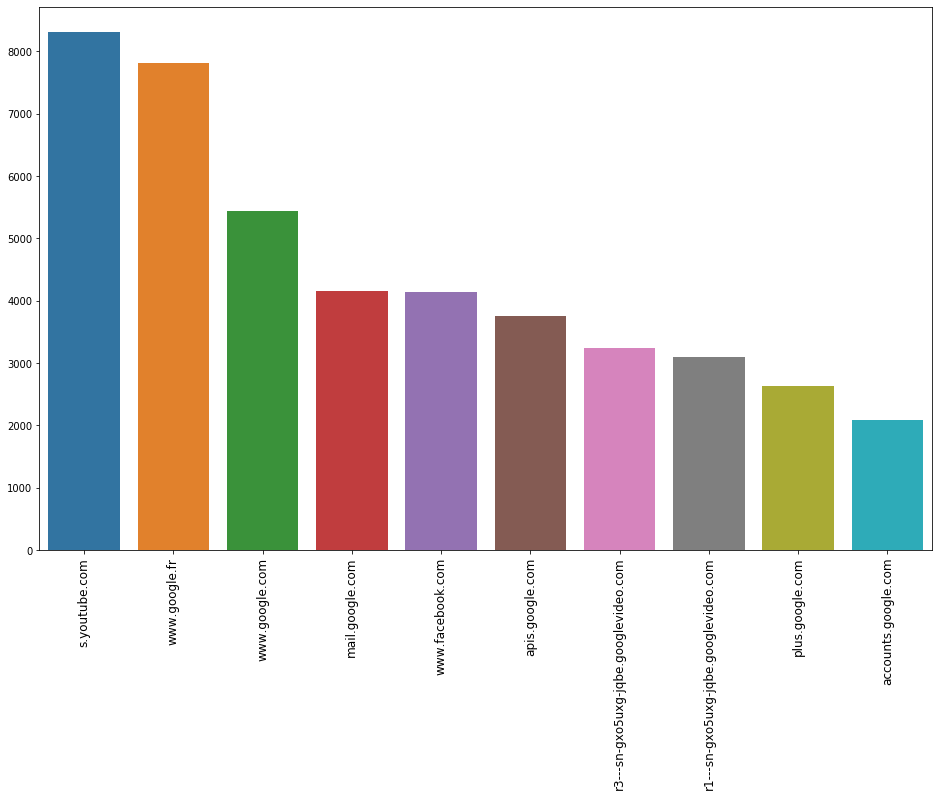

In [26]:
fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(top10_sites, top10_freqs, ax=ax)
g.set_xticklabels(rotation=90, labels=top10_sites, fontsize=12);

Другой вариант визуализации этой же информации, который мне нравится больше.

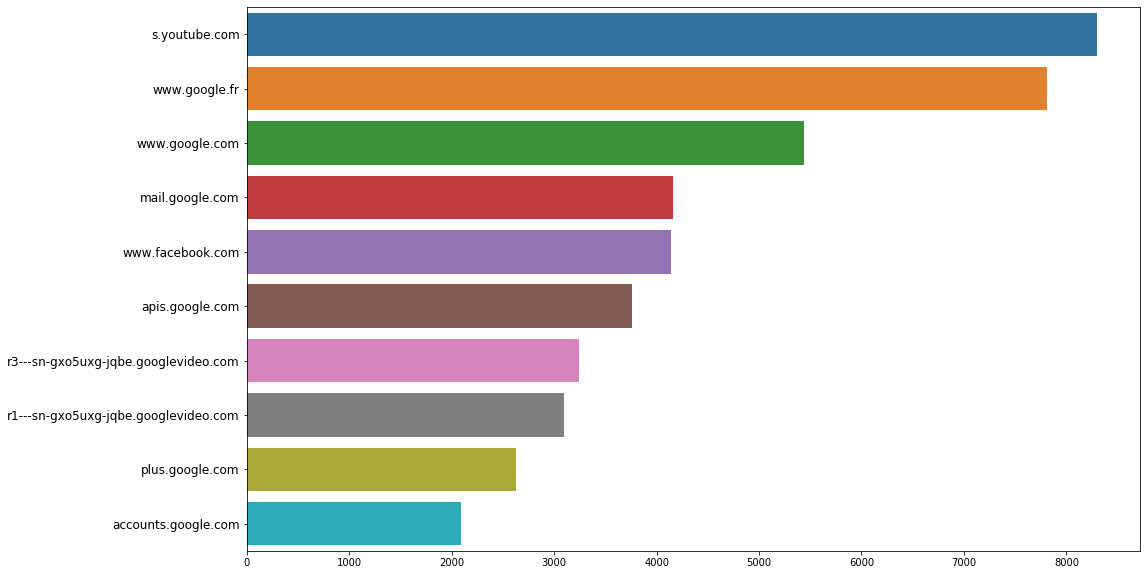

In [27]:
fig, ax = plt.subplots(figsize=(16, 10))
g = sns.barplot(top10_freqs, top10_sites, ax=ax)
g.set_yticklabels(labels=top10_sites, fontsize=12);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

## Решение

Я добавлю следующие бинарные признаки по времени суток: ночь, утро, день, вечер, поздний вечер (<b>night, morning, afternoon, evening, late_evening</b>). Границы взяты из визуального анализа графика времени старта сессии для 150 пользователей, который можно увидеть ниже. Также добавим один бинарный признак по дням недели: выходной день (<b>weekend</b>).

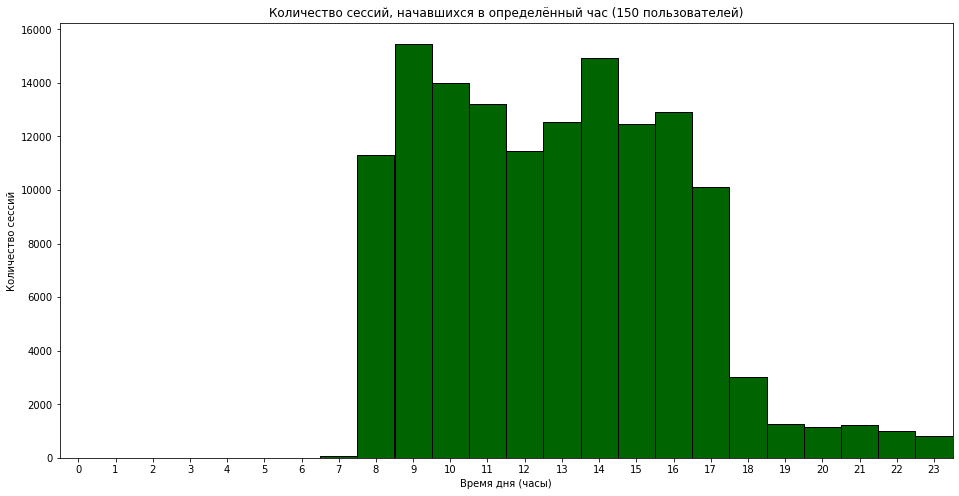

In [28]:
plt.figure(figsize=(16,8))
plt.hist(train_data_150users['start_hour'], bins=24, color='darkgreen', range=(-0.5,23.5), ec='black')
plt.title('Количество сессий, начавшихся в определённый час (150 пользователей)')
plt.ylabel('Количество сессий')
plt.xlim((-0.5,23.5))
plt.xticks(range(24))
plt.xlabel('Время дня (часы)');

Так как у нас не было потеряно никакой информации при создании train_data_XXXusers, я предпочту передать в функцию этот датафрейм, вместо повторного считывания информации из исходных файлов.

In [29]:
def feature_engineering(train_data, new_features, session_length=10, window_size=10):
    hour = train_data['start_hour']
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    afternoon = ((hour >= 12) & (hour <= 14)).astype('int')
    evening = ((hour >= 15) & (hour <= 18)).astype('int')
    late_evening = ((hour >= 19) & (hour <= 23)).astype('int')
    weekend = (train_data['day_of_week'] >= 5).astype('int')
    X = np.hstack([night.values.reshape(-1, 1), morning.values.reshape(-1, 1), 
                afternoon.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                late_evening.values.reshape(-1, 1), weekend.values.reshape(-1, 1)])
    data = pd.DataFrame(X, columns=new_features)
    data['target'] = train_data['target']
    return data

In [30]:
new_features = ['night', 'morning', 'afternoon', 'evening', 'late_evening', 'weekend']
new_features_10users = feature_engineering(train_data_10users, new_features)

In [31]:
new_features_150users = feature_engineering(train_data_150users, new_features)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Построим распределение по времени суток для каждого пользователя.

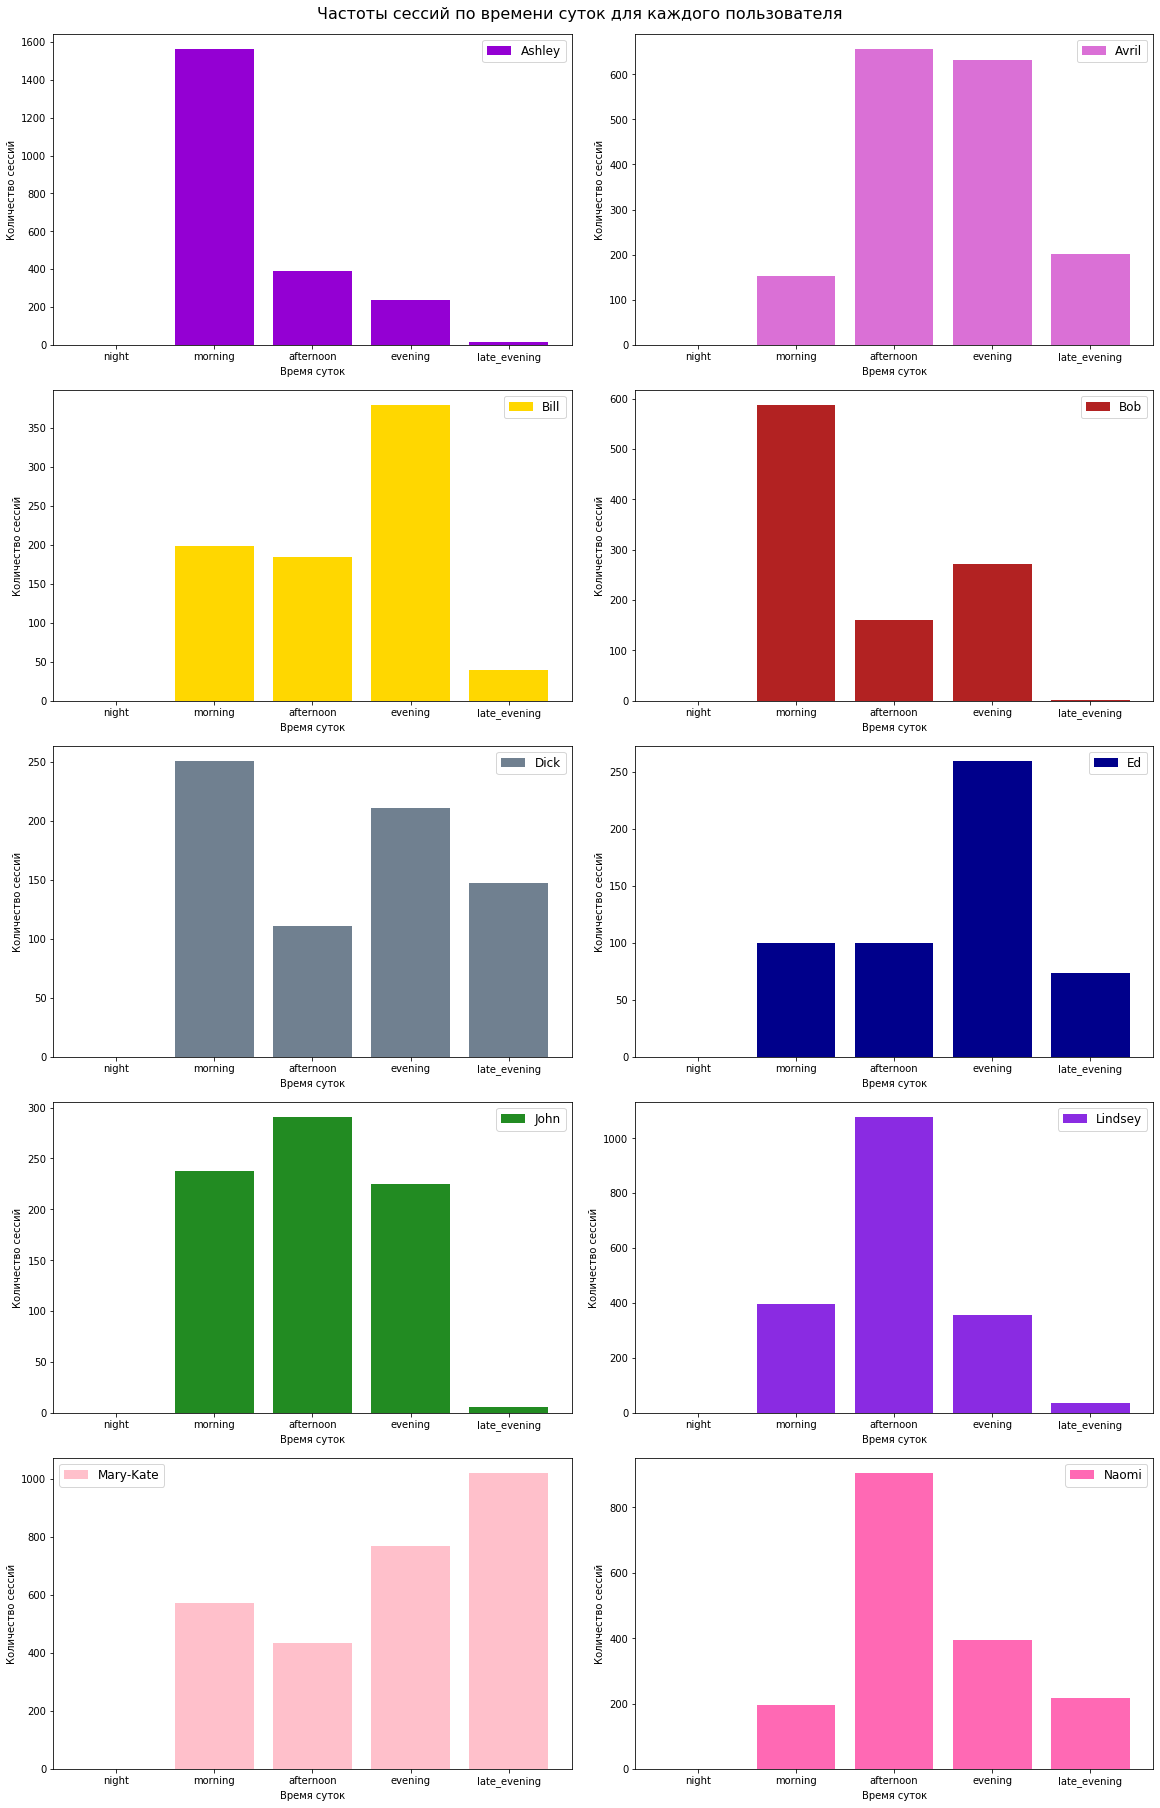

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 25), constrained_layout=True)

for idx, (user, sub_df) in  enumerate(new_features_10users.groupby(['target'])):
    ax = axes[idx//2][idx%2]
    counts = [sub_df[feature].sum() for feature in new_features[:-1]]
    ax.bar(new_features[:-1], counts, color=color_dic[user], label=user)
    ax.set_ylabel('Количество сессий')
    ax.set_xlabel('Время суток')
    ax.legend(fontsize=12)
fig.suptitle('Частоты сессий по времени суток для каждого пользователя', fontsize=16)
plt.show()

Мы видим, что теперь намного проще видеть разницу в привычках пользователей, в то время как для start_hour она слишком размазана.

Построим также единый график для всех пользователей для отношения количества сессий в выходной день к общему количеству сессий.

In [33]:
users = []
values = []
for idx, (user, sub_df) in  enumerate(new_features_10users.groupby(['target'])):
    users.append(user)
    values.append(sub_df['weekend'].sum() / (float)(len(sub_df['weekend'])))

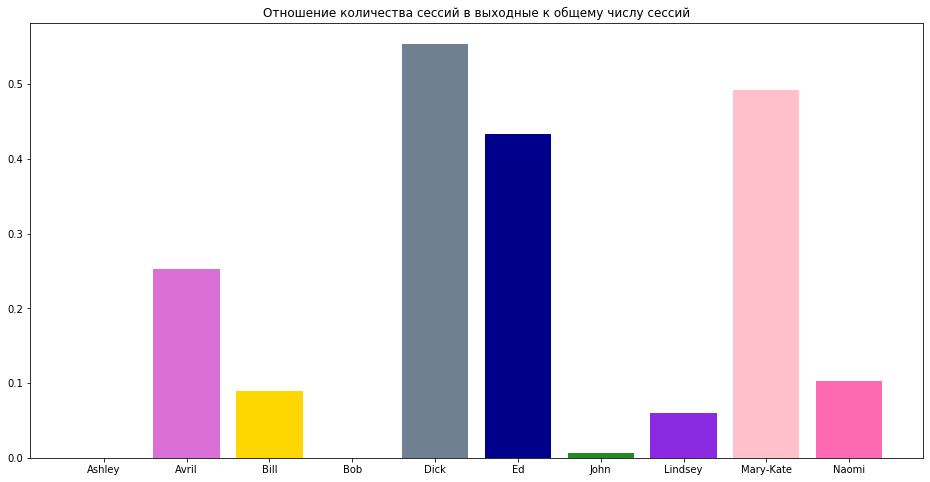

In [34]:
colors = [color_dic[user] for user in users]
plt.figure(figsize=(16,8))
plt.title('Отношение количества сессий в выходные к общему числу сессий')
plt.bar(users, values, color=colors);

Мы видим, что созданный признак довольно хорошо определяет пользователей, намного нагляднее, чем day_of_week.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

Я предполагаю, что признаки start_hour и day_of_week могут переобучить модель (первый точно), поэтому в итоговый выбор они не включены.

In [35]:
selected_features_10users = pd.concat([train_data_10users[['session_timespan', '#unique_sites']],
                                       new_features_10users.drop('target', axis=1)],
                                      axis=1)
selected_features_150users = pd.concat([train_data_150users[['session_timespan', '#unique_sites']],
                                        new_features_150users.drop('target', axis=1)],
                                       axis=1)

In [36]:
selected_features_10users.head()

,session_timespan,#unique_sites,night,morning,afternoon,evening,late_evening,weekend
0,33,5,0,1,0,0,0,0
1,284,10,0,1,0,0,0,0
2,258,7,0,1,0,0,0,0
3,30,6,0,1,0,0,0,0
4,6,9,0,1,0,0,0,0


In [37]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)#, protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)#, protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 